<a href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH03_FLYNN_ML4DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3: Ligand-based Screening: Machine Learning

## Setup

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 68.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
np.random.seed(42)

In [ ]:
import seaborn as sns
colors = ["#A20025", "#6C8EBF"]
sns.set_palette(sns.color_palette(colors))

In [ ]:
import rdkit

## Data Acquisition, Exploration, & Curation

### Loading and Exploring the hERG Blockers Dataset

In [ ]:
from pathlib import Path
import pandas as pd
import urllib.request

def load_herg_blockers_data():
  herg_blockers_path = Path("data/hERG_blockers.xlsx")

  if not herg_blockers_path.is_file():
    Path("data").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/nrflynn2/ml-drug-discovery/blob/main/data/hERG_blockers.xlsx"
    urllib.request.urlretrieve(url, herg_blockers_path)

  return pd.read_excel(
      herg_blockers_path,
      usecols="A:F",
      header=None,
      skiprows=[0,1,],
      names=["SMILES", "Name", "pIC50", "Class", "Scaffold Split", "Random Split"],
    ).head(-68)

herg_blockers = load_herg_blockers_data()

In [ ]:
herg_blockers.head()

,SMILES,Name,pIC50,Class,Scaffold Split,Random Split
0,Fc1ccc(cc1)Cn1c2c(nc1NC1CCN(CC1)CCc1ccc(O)cc1)...,DEMETHYLASTEMIZOLE,9.000000,1,Training I,Training II
1,Fc1ccc(cc1)C(OCC[NH+]1CC[NH+](CC1)CCCc1ccccc1)...,GBR-12909,9.000000,1,Training I,Training II
2,O=[N+]([O-])c1ccc(cc1)CCCCN(CCCCCCC)CC,LY-97241,8.795880,1,Training I,Training II
3,CCCCCCC[N+](CC)(CC)CCCCc1ccc(cc1)Cl.CCCCCCC[N+...,CLOFILIUM PHOSPHATE,8.585027,1,Training I,Training II
4,Fc1ccc(cc1)C(CCC[NH+]1CCC2(N(CNC2=O)c2ccccc2)C...,FLUSPIRILENE,8.522879,1,Training I,Training II


In [ ]:
herg_blockers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SMILES          587 non-null    object 
 1   Name            565 non-null    object 
 2   pIC50           526 non-null    float64
 3   Class           587 non-null    int64  
 4   Scaffold Split  587 non-null    object 
 5   Random Split    587 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 27.6+ KB


**Code for Figure 3.2. Comparison between distributions of the real dataset and a version with simulated annotation error**

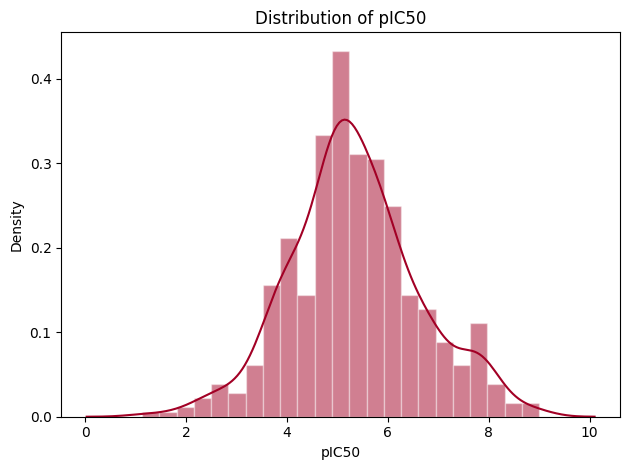

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(
    herg_blockers["pIC50"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4),
)
plt.title("Distribution of pIC50")
plt.tight_layout()
plt.savefig("distribution_pic50.svg", bbox_inches='tight', dpi=600)
plt.savefig("distribution_pic50.png", bbox_inches='tight', dpi=600);

<ipython-input-18-eac150136182>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  herg_blockers["pIC50"].append(simulated_error, ignore_index=True), kde=True,


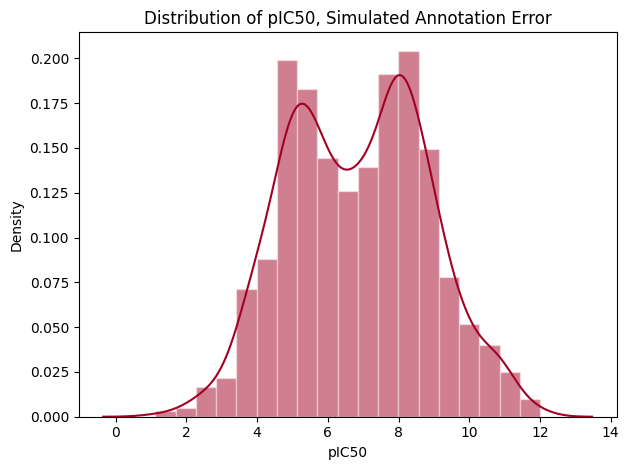

In [ ]:
simulated_error = herg_blockers["pIC50"] + 3.0
sns.histplot(
    herg_blockers["pIC50"].append(simulated_error, ignore_index=True), kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4),
)
plt.title("Distribution of pIC50, Simulated Annotation Error")
plt.tight_layout();
plt.savefig("distribution_pic50_error.svg", bbox_inches='tight', dpi=600)
plt.savefig("distribution_pic50_error.png", bbox_inches='tight', dpi=600);

### Validating & Standardizing SMILES

**Code for Figure 3.3. Example molecules with highest (top row) and lowest (bottom row) experimentally measured pIC50**

In [ ]:
from rdkit.Chem import Draw
d2d = Draw.MolDraw2DSVG(-1, -1)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.setHighlightColour((.635,.0,.145,.4))
dopts.additionalAtomLabelPadding = 0.15

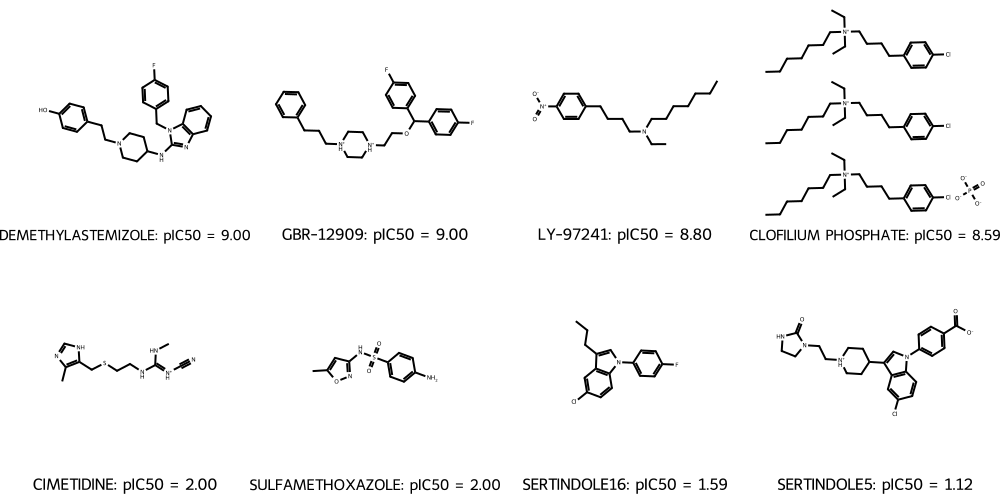

In [ ]:
extremes = pd.concat([herg_blockers[:4], herg_blockers.dropna()[-4:]])
legend_text = [
    f"{x.Name}: pIC50 = {x.pIC50:.2f}" for x in extremes.itertuples()
]
extreme_mols = [rdkit.Chem.MolFromSmiles(smi) for smi in extremes.SMILES]
img = Draw.MolsToGridImage(
    extreme_mols, molsPerRow=4, subImgSize=(250, 250), legends=legend_text, useSVG=True, drawOptions=dopts,
)
img

In [ ]:
with open("rdkit_extremes.svg", "w") as f:
  f.write(img.data)

**Code for Figure 3.5. Example molecules before and after standardization**

In [ ]:
from rdkit.Chem.MolStandardize.rdMolStandardize import (
    Cleanup,
    LargestFragmentChooser,
    TautomerEnumerator,
    Uncharger
)

def process_smiles(smi):
  mol = rdkit.Chem.MolFromSmiles(smi)
  mol = Cleanup(mol)
  mol = LargestFragmentChooser().choose(mol)
  mol = Uncharger().uncharge(mol)

  return TautomerEnumerator().Canonicalize(mol)

herg_blockers["mol"] = herg_blockers["SMILES"].apply(process_smiles)

[17:13:34] Initializing MetalDisconnector
[17:13:34] Running MetalDisconnector
[17:13:34] Initializing Normalizer
[17:13:34] Running Normalizer
[17:13:34] Running LargestFragmentChooser
[17:13:34] Fragment: Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1
[17:13:34] New largest fragment: Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1 (62)
[17:13:34] Running Uncharger
[17:13:34] Initializing MetalDisconnector
[17:13:34] Running MetalDisconnector
[17:13:34] Initializing Normalizer
[17:13:34] Running Normalizer
[17:13:34] Running LargestFragmentChooser
[17:13:34] Fragment: Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2ccc(F)cc2)cc1
[17:13:34] New largest fragment: Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2ccc(F)cc2)cc1 (67)
[17:13:34] Running Uncharger
[17:13:34] Initializing MetalDisconnector
[17:13:34] Running MetalDisconnector
[17:13:34] Initializing Normalizer
[17:13:34] Running Normalizer
[17:13:34] Running LargestFragmentChooser
[17:13:34] Fragment: CCCCCCCN(CC)CCCCc1ccc([N+](=O

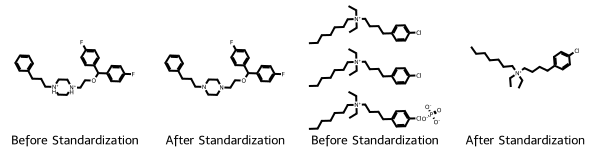

In [ ]:
before_and_after_mols = [rdkit.Chem.MolFromSmiles(herg_blockers.iloc[1].SMILES), herg_blockers.iloc[1].mol, rdkit.Chem.MolFromSmiles(herg_blockers.iloc[3].SMILES), herg_blockers.iloc[3].mol]
legend_text = ["Before Standardization", "After Standardization"] * 2
img = Draw.MolsToGridImage(
    before_and_after_mols, molsPerRow=4, subImgSize=(150, 150), legends=legend_text, useSVG=True, drawOptions=dopts,
)
img

In [ ]:
with open("rdkit_before_and_after.svg", "w") as f:
  f.write(img.data)

### Feature Generation & Exploration

In [ ]:
from rdkit.Chem import Descriptors
print(len(Descriptors._descList))
print(Descriptors._descList[:5])

209
[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x7b32f1cab910>), ('MaxEStateIndex', <function MaxEStateIndex at 0x7b32f1caa200>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x7b32f1cab9a0>), ('MinEStateIndex', <function MinEStateIndex at 0x7b32f1cab760>), ('qed', <function qed at 0x7b32f1cedcf0>)]


In [ ]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

def compute_fingerprint(mol: rdkit.Chem.Mol, r: int, nBits: int) -> np.ndarray:
    """Featurize Rdkit Mol into Morgan Fingerprint bit vectors.

     Args:
         mol: an Rdkit Mol object (representing a molecule).

     Returns:
         numpy.ndarray: A 1-D numpy array of the featurized molecule.
    """
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits=nBits)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

fingerprints = np.stack([compute_fingerprint(mol, 2, 2048) for mol in herg_blockers.mol])
fingerprints.shape

(587, 2048)

**Code for Figure 3.6. Exploration data analysis of fingerprint features**

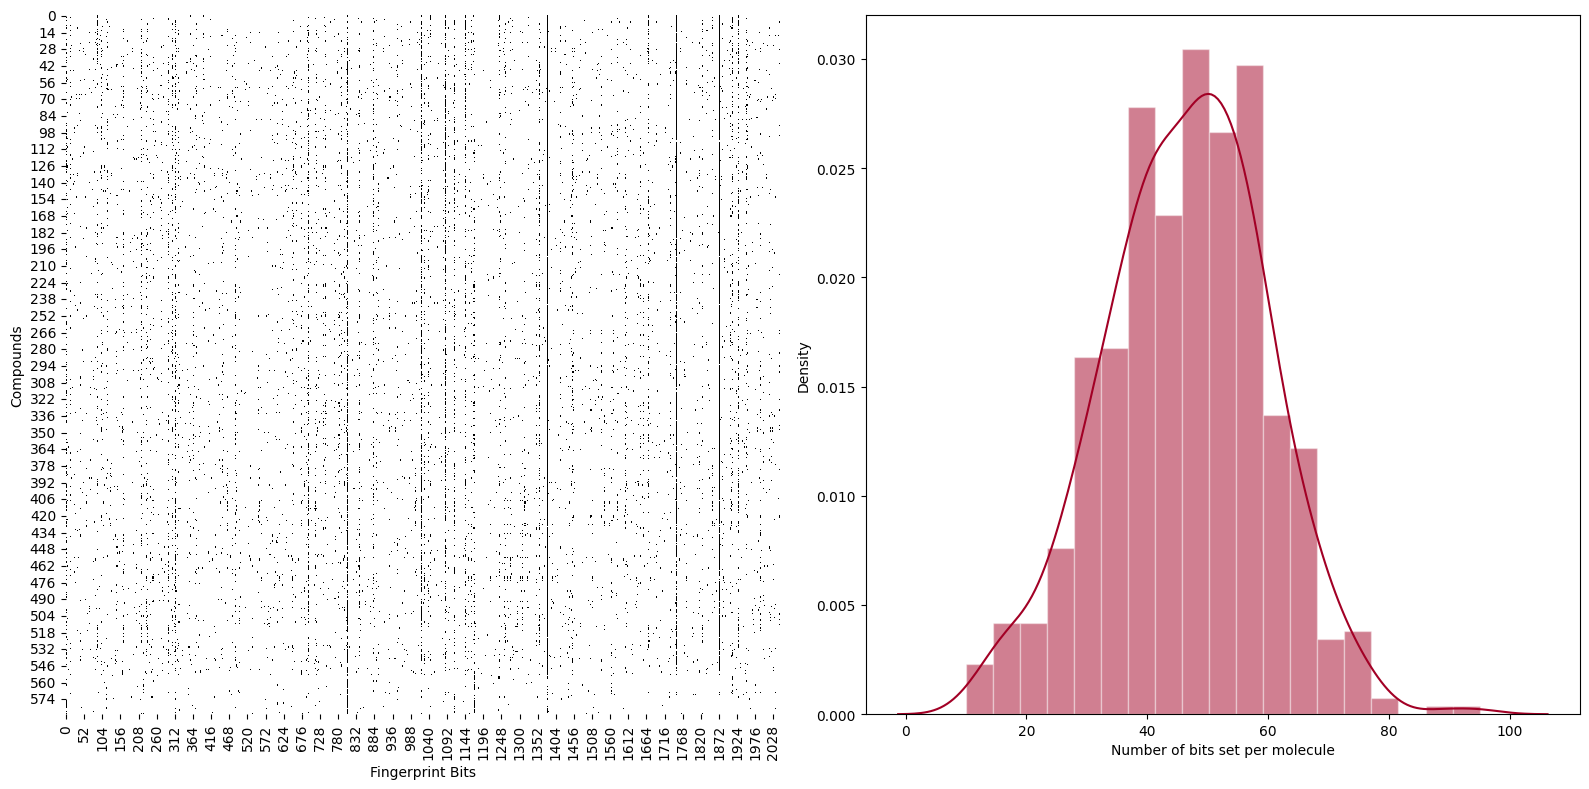

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.heatmap(fingerprints, cbar=False, cmap=plt.cm.Greys, ax=ax[0])
ax[0].set_xlabel("Fingerprint Bits")
ax[0].set_ylabel("Compounds")

sns.histplot(
    fingerprints.sum(axis=1), kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4), ax=ax[1]
)
ax[1].set_xlabel("Number of bits set per molecule")
fig.tight_layout();
plt.savefig("fingerprint_eda.svg", bbox_inches='tight', dpi=600)
plt.savefig("fingerprint_eda.png", bbox_inches='tight', dpi=600)

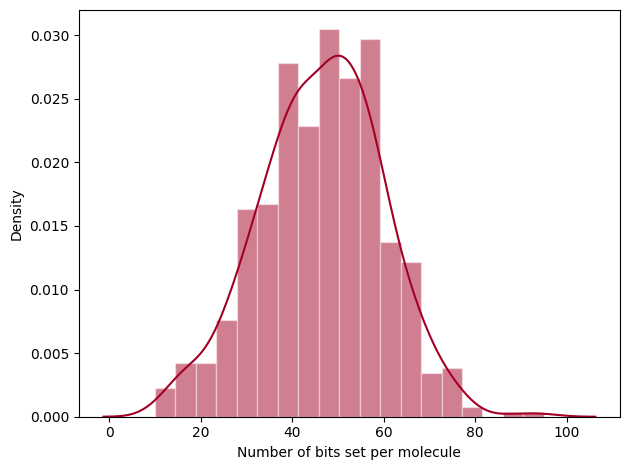

In [ ]:
fig, axes =plt.subplots(1, 1) #(1, 2)

sns.histplot(
    fingerprints.sum(axis=1), kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4), ax=axes
)
axes.set_xlabel("Number of bits set per molecule")

#sns.histplot(fingerprints.sum(axis=0), ax=axes[1])
#axes[1].set_xlabel("Number of molecule's setting a specific bit")

fig.tight_layout()
plt.savefig("fingerprint_eda.svg", bbox_inches='tight', dpi=600)
plt.savefig("fingerprint_eda.png", bbox_inches='tight', dpi=600)

## Application of Linear Models

### Training our Linear Model

In [ ]:
from sklearn.linear_model import SGDClassifier

def split_data(df, split_col="Random Split"):
  train_indices = df.index[df[split_col].str.contains("Train")].tolist()
  test_indices = df.index[df[split_col].str.contains("Test")].tolist()
  return (
    df.iloc[train_indices].sample(frac=1).reset_index(drop=True),
    df.iloc[test_indices].sample(frac=1).reset_index(drop=True)
  )

train_set, test_set = split_data(herg_blockers)

In [ ]:
train_fingerprints = np.stack([compute_fingerprint(mol, 2, 2048) for mol in train_set.mol])
train_labels = train_set.Class

lin_cls = SGDClassifier()
lin_cls.fit(train_fingerprints, train_labels)

SGDClassifier()

In [ ]:
herg_blockers_predictions = lin_cls.predict(train_fingerprints)
herg_blockers_predictions[:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
train_labels.iloc[:10].values

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

### Evaluating our Linear Model

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(train_labels, herg_blockers_predictions)

0.9617346938775511

In [ ]:
from sklearn.model_selection import cross_validate

scoring = {'acc': 'accuracy'}
lin_cls_scores = cross_validate(lin_cls, train_fingerprints, train_labels, scoring=scoring, cv=5)
lin_cls_scores["test_acc"].mean()

0.7756247971437845

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(train_fingerprints, train_labels)
accuracy_score(train_labels, dummy_clf.predict(train_fingerprints))

0.6938775510204082

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_labels, herg_blockers_predictions)

array([[107,  13],
       [  2, 270]])

In [ ]:
scoring = {
  'acc': 'accuracy',
  'prec_macro': 'precision',
  'rec_macro': 'recall',
  'f1_macro': 'f1',
}
lin_cls_scores = cross_validate(lin_cls, train_fingerprints, train_labels, scoring=scoring, cv=5, return_train_score=True)
lin_cls_scores_df = pd.DataFrame.from_dict(lin_cls_scores)
lin_cls_scores_df.describe().round(3)

,fit_time,score_time,test_acc,train_acc,test_prec_macro,train_prec_macro,test_rec_macro,train_rec_macro,test_f1_macro,train_f1_macro
count,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000
mean,0.020,0.005,0.796,0.975,0.836,0.974,0.882,0.992,0.856,0.982
std,0.004,0.001,0.048,0.017,0.039,0.027,0.081,0.007,0.039,0.012
min,0.013,0.004,0.722,0.949,0.806,0.935,0.764,0.982,0.792,0.964
25%,0.018,0.005,0.782,0.968,0.820,0.956,0.870,0.991,0.847,0.978
50%,0.020,0.005,0.808,0.984,0.824,0.991,0.870,0.991,0.870,0.988
75%,0.022,0.006,0.823,0.987,0.825,0.991,0.926,0.995,0.885,0.991
max,0.025,0.006,0.846,0.987,0.904,0.995,0.982,1.000,0.887,0.991


**Code for Figure 3.11. Discrepancies between training and validation performance across several binary classification metrics**

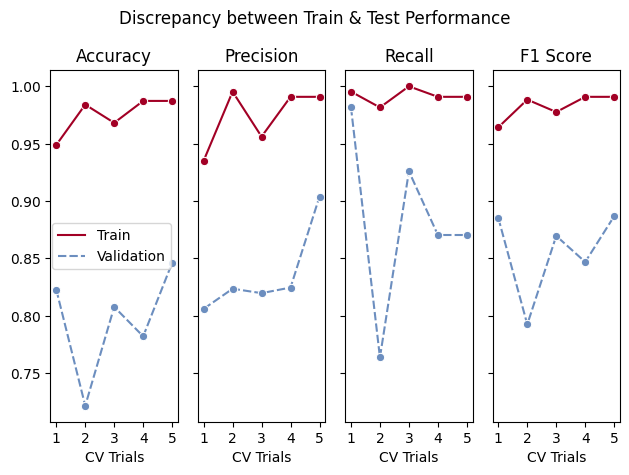

In [ ]:
fig, axes =plt.subplots(1, 4, sharey=True)
fig.suptitle("Discrepancy between Train & Test Performance")

sns.lineplot(ax=axes[0], data=[lin_cls_scores_df["train_acc"], lin_cls_scores_df["test_acc"]], marker="o")
axes[0].set_xticks(range(len(lin_cls_scores_df)))
axes[0].set_xticklabels([1, 2, 3, 4, 5])
axes[0].set_title("Accuracy")
axes[0].set_xlabel("CV Trials")

sns.lineplot(ax=axes[1], data=[lin_cls_scores_df["train_prec_macro"], lin_cls_scores_df["test_prec_macro"]], legend=False, marker="o")
axes[1].set_xticks(range(len(lin_cls_scores_df)))
axes[1].set_xticklabels([1, 2, 3, 4, 5])
axes[1].set_title("Precision")
axes[1].set_xlabel("CV Trials")

sns.lineplot(ax=axes[2], data=[lin_cls_scores_df["train_rec_macro"], lin_cls_scores_df["test_rec_macro"]], legend=False, marker="o")
axes[2].set_xticks(range(len(lin_cls_scores_df)))
axes[2].set_xticklabels([1, 2, 3, 4, 5])
axes[2].set_title("Recall")
axes[2].set_xlabel("CV Trials")

sns.lineplot(ax=axes[3], data=[lin_cls_scores_df["train_f1_macro"], lin_cls_scores_df["test_f1_macro"]], legend=False, marker="o")
axes[3].set_xticks(range(len(lin_cls_scores_df)))
axes[3].set_xticklabels([1, 2, 3, 4, 5])
axes[3].set_title("F1 Score")
axes[3].set_xlabel("CV Trials")

fig.tight_layout()
axes[0].legend(handles=axes[0].get_legend_handles_labels()[0], labels=["Train", "Validation"])
plt.savefig("cv_metrics_discrepancy.svg", bbox_inches='tight', dpi=600)
plt.savefig("cv_metrics_discrepancy.png", bbox_inches='tight', dpi=600)

## Fine-tuning our Model

### Regularization

**Code for Figure 3.12. Distribution of unregularized model weights**

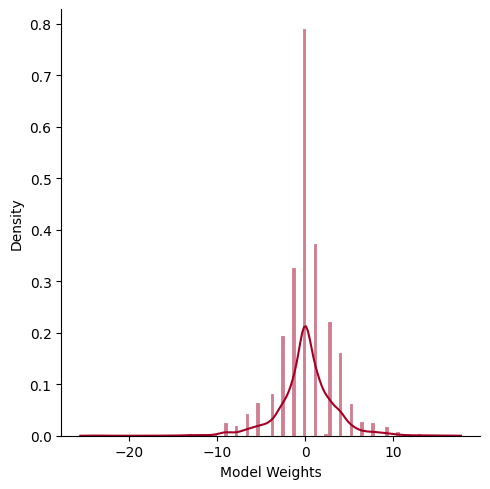

In [ ]:
model_weights = lin_cls.coef_.squeeze()
sns.displot(
    model_weights, kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4),
)
plt.xlabel("Model Weights")
plt.tight_layout()
plt.savefig("model_weights_displot.svg", bbox_inches='tight', dpi=600)
plt.savefig("model_weights_displot.png", bbox_inches='tight', dpi=600)

### Hyperparameter Tuning

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class SmilesToMols(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def _process_smiles(self, smi):

    return TautomerEnumerator().Canonicalize(
        Uncharger().uncharge(
            LargestFragmentChooser().choose(
                Cleanup(rdkit.Chem.MolFromSmiles(smi))
            )
        )
    )

  def transform(self, X, y=None):
    mols = [self._process_smiles(smi) for smi in X]
    return np.asarray(mols)

class FingerprintFeaturizer(BaseEstimator, TransformerMixin):
  def __init__(self, radius=2, nBits=2048):
    self.radius = radius
    self.nBits = nBits

  def _fp_to_numpy(self, fp):
    output = []
    for f in fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):

    fp = [
      AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.nBits)
      for mol in X
    ]
    return self._fp_to_numpy(fp)


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures

cache_dir = "gs_linear_sgd"
pipe_linear_sgd = make_pipeline(
  SmilesToMols(),  # Transformer: Load & standardize SMILES
  FingerprintFeaturizer(),  # Transformer: Feature generation step
  SGDClassifier(),  # Estimator: SGDClassifier (Logistic Regressor)
  memory=cache_dir
)

param_grid_linear_sgd = [{
  'sgdclassifier__penalty': ["l2", "l1"],
  'sgdclassifier__alpha': [1e-3, 1e-2, 1e-1],
  'fingerprintfeaturizer__radius': [2, 4],
  'fingerprintfeaturizer__nBits': [1024, 2048],
}]

gs_linear_sgd = GridSearchCV(
  estimator=pipe_linear_sgd,
  param_grid=param_grid_linear_sgd,
  scoring="f1",
  cv=5,
  verbose=1,
)

gs_linear_sgd.fit(train_set.SMILES, train_set.Class)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Streaming output truncated to the last 5000 lines.
[17:17:19] Running Uncharger
[17:17:19] Initializing MetalDisconnector
[17:17:19] Running MetalDisconnector
[17:17:19] Initializing Normalizer
[17:17:19] Running Normalizer
[17:17:19] Running LargestFragmentChooser
[17:17:19] Fragment: NCC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1
[17:17:19] New largest fragment: NCC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1 (37)
[17:17:19] Running Uncharger
[17:17:19] Initializing MetalDisconnector
[17:17:19] Running MetalDisconnector
[17:17:19] Initializing Normalizer
[17:17:19] Running Normalizer
[17:17:19] Running LargestFragmentChooser
[17:17:19] Fragment: N#Cc1ccc(Cn2cncc2C[NH2+][C@@H]2CCN(Cc3cccc(Cl)c3)C2=O)cc1
[17:17:19] New largest fragment: N#Cc1ccc(Cn2cncc2C[NH2+][C@@H]2CCN(Cc3cccc(Cl)c3)C2=O)cc1 (53)
[17:17:19] Running Uncharger
[17:17:19] Removed positive charge.
[17:17:19] Initializing MetalDisconnector
[17:17:19] Running MetalDisconnector
[17:17:19] Initializing Normalizer
[17:17:19] Running Normalizer


GridSearchCV(cv=5,
             estimator=Pipeline(memory='gs_linear_sgd',
                                steps=[('smilestomols', SmilesToMols()),
                                       ('fingerprintfeaturizer',
                                        FingerprintFeaturizer()),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid=[{'fingerprintfeaturizer__nBits': [1024, 2048],
                          'fingerprintfeaturizer__radius': [2, 4],
                          'sgdclassifier__alpha': [0.001, 0.01, 0.1],
                          'sgdclassifier__penalty': ['l2', 'l1']}],
             scoring='f1', verbose=1)

In [ ]:
gs_linear_sgd.best_params_

{'fingerprintfeaturizer__nBits': 2048,
 'fingerprintfeaturizer__radius': 2,
 'sgdclassifier__alpha': 0.1,
 'sgdclassifier__penalty': 'l2'}

In [ ]:
gs_linear_sgd.best_score_

0.8809258265665167

In [ ]:
gs_linear_sgd_cv_res = pd.DataFrame(gs_linear_sgd.cv_results_)
gs_linear_sgd_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
gs_linear_sgd_cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fingerprintfeaturizer__nBits,param_fingerprintfeaturizer__radius,param_sgdclassifier__alpha,param_sgdclassifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,0.088446,0.008000,0.905184,0.135184,2048,2,0.1,l2,"{'fingerprintfeaturizer__nBits': 2048, 'finger...",0.907563,0.868852,0.869565,0.849558,0.909091,0.880926,0.023502,1
22,0.094093,0.010086,0.990920,0.259247,2048,4,0.1,l2,"{'fingerprintfeaturizer__nBits': 2048, 'finger...",0.905983,0.854701,0.867257,0.849057,0.905660,0.876531,0.024631,2
4,0.078938,0.010116,0.928693,0.168193,1024,2,0.1,l2,"{'fingerprintfeaturizer__nBits': 1024, 'finger...",0.879310,0.823529,0.869565,0.852174,0.909091,0.866734,0.028422,3
18,0.177991,0.003616,0.875647,0.132598,2048,4,0.001,l2,"{'fingerprintfeaturizer__nBits': 2048, 'finger...",0.885246,0.861789,0.807692,0.867925,0.886792,0.861889,0.028773,4
14,0.086072,0.010131,0.884074,0.132569,2048,2,0.01,l2,"{'fingerprintfeaturizer__nBits': 2048, 'finger...",0.879310,0.818182,0.849558,0.844037,0.895238,0.857265,0.027166,5


In [ ]:
from scipy.stats import uniform as sp_rand

pipe_nonlinear_sgd = make_pipeline(
  FingerprintFeaturizer(),  # Transformer: Feature generation step
  PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),  # Transformer: Nonlinear feature transform
  SGDClassifier(max_iter=5000, early_stopping=True),  # Estimator: SGDClassifier (Logistic Regressor)
  memory="rs_nonlinear_sgd"
)

param_dist_nonlinear_sgd = [{
  'sgdclassifier__penalty': ["l1", "l2"],
  'sgdclassifier__alpha': sp_rand(),
  'fingerprintfeaturizer__radius': [2, 4],
  'fingerprintfeaturizer__nBits': [64, 128, 256],
}]

rs_nonlinear_sgd = RandomizedSearchCV(
  estimator=pipe_nonlinear_sgd,
  param_distributions=param_dist_nonlinear_sgd,
  scoring="f1",
  cv=5,
  n_iter=20,
)

rs_nonlinear_sgd.fit(train_set.mol, train_set.Class)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(memory='rs_nonlinear_sgd',
                                      steps=[('fingerprintfeaturizer',
                                              FingerprintFeaturizer()),
                                             ('polynomialfeatures',
                                              PolynomialFeatures(include_bias=False,
                                                                 interaction_only=True)),
                                             ('sgdclassifier',
                                              SGDClassifier(early_stopping=True,
                                                            loss='squared_error',
                                                            max_iter=5000))]),
                   n_iter=20,
                   param_distributions=[{'fingerprintfeaturizer__nBits': [64,
                                                                          128,
                                                                          256],
                                         'fingerprintfeaturizer__radius': [2,
                                                                           4],
                                         'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b32f0a85e10>,
                                         'sgdclassifier__penalty': ['l1',
                                                                    'l2']}],
                   scoring='f1')

In [ ]:
rs_nonlinear_sgd.best_params_

{'fingerprintfeaturizer__nBits': 128,
 'fingerprintfeaturizer__radius': 2,
 'sgdclassifier__alpha': 0.36469724945730586,
 'sgdclassifier__penalty': 'l2'}

In [ ]:
rs_nonlinear_sgd.best_score_

0.6930966168199139

In [ ]:
final_model = gs_linear_sgd.best_estimator_

### Evaluating the Best Model

**Code for Figure 3.14. Distribution of regularized model weights**

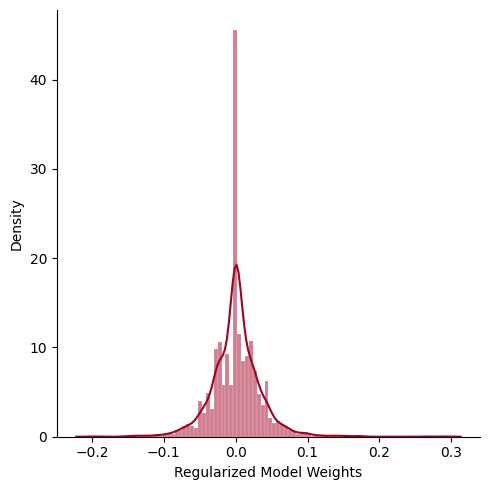

In [ ]:
model_weights = final_model.named_steps["sgdclassifier"].coef_.squeeze()
sns.displot(
    model_weights, kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4),
)
plt.xlabel("Regularized Model Weights")
plt.tight_layout()
plt.savefig("regularized_model_weights_displot.svg", bbox_inches='tight', dpi=600)
plt.savefig("regularized_model_weights_displot.png", bbox_inches='tight', dpi=600)

**Code for Figure 3.15. Example mapping of structures with high positive and negative association with hERG blockage**

In [ ]:
important_bits = np.argwhere(model_weights).flatten()
important_bits.shape

(1688,)

In [ ]:
model_weights.shape

(2048,)

In [ ]:
model_weights = final_model.named_steps["sgdclassifier"].coef_.squeeze()
N = 3

top_ind_unsorted = np.argpartition(model_weights, -N)[-N:]
top_ind_sorted = top_ind_unsorted[np.argsort(model_weights[top_ind_unsorted])[::-1]]

bot_ind_unsorted = np.argpartition(model_weights, N)[:N]
bot_ind_sorted = bot_ind_unsorted[np.argsort(model_weights[bot_ind_unsorted])]

print(top_ind_sorted)
print(bot_ind_sorted)

top_bit_coefficients = model_weights[top_ind_sorted]
bot_bit_coefficients = model_weights[bot_ind_sorted]

print(top_bit_coefficients)
print(bot_bit_coefficients)

[1750 1088 1480]
[1171  656 1294]
[0.29037668 0.26405359 0.17356793]
[-0.19906844 -0.15300301 -0.14724483]


In [ ]:
def draw_fragment_from_bit(mol, bit_number):
  """ Given an rdkit mol, draws the local fragment that corresponds to the set bit of ecfp featurization.

  If the bit is not set, will throw an error.
  """
  bi = {}
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
  try:
    svg = rdkit.Chem.Draw.DrawMorganBit(mol, bit_number, bi, useSVG=True)
  except:
    raise ValueError(f"Featurization of mol doesn't have bit {bit_number} set")
  return svg

def get_examples_for_bit(bit_number, mols, fingerprints):
  """ For a given bit number, get a visual representation of what substructure it represents"""
  res = np.argwhere(fingerprints[:, bit_number] == 1)
  mols = np.array(mols)[res.flatten()]
  return [draw_fragment_from_bit(mols[i], bit_number) for i in range(len(mols))]

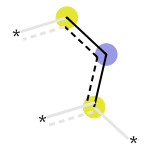

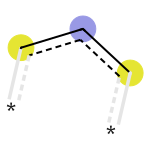

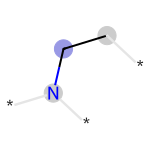

In [ ]:
for i, bit in enumerate(top_ind_sorted):
  examples = get_examples_for_bit(bit, train_set.mol, train_fingerprints)
  with open(f"top_example_bit{i}.svg", "w") as f:
    f.write(examples[0].data)
  display(examples[0])

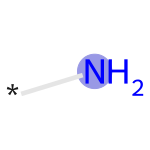

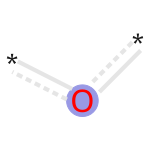

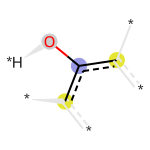

In [ ]:
for i, bit in enumerate(bot_ind_sorted):
  examples = get_examples_for_bit(bit, train_set.mol, train_fingerprints)
  with open(f"bot_example_bit{i}.svg", "w") as f:
    f.write(examples[0].data)
  display(examples[0])

In [ ]:
from sklearn.metrics import f1_score, matthews_corrcoef
test_preds = final_model.predict(test_set.SMILES)
f1_score(test_set.Class, test_preds)

[18:10:42] Initializing MetalDisconnector
[18:10:42] Running MetalDisconnector
[18:10:42] Initializing Normalizer
[18:10:42] Running Normalizer
[18:10:42] Running LargestFragmentChooser
[18:10:42] Fragment: CC(C)(C)[C@H](O)C(=O)N1CC(c2cc(F)ccc2F)=C[C@H]1c1cccc(O)c1
[18:10:42] New largest fragment: CC(C)(C)[C@H](O)C(=O)N1CC(c2cc(F)ccc2F)=C[C@H]1c1cccc(O)c1 (51)
[18:10:42] Running Uncharger
[18:10:42] Initializing MetalDisconnector
[18:10:42] Running MetalDisconnector
[18:10:42] Initializing Normalizer
[18:10:42] Running Normalizer
[18:10:42] Running LargestFragmentChooser
[18:10:42] Fragment: [N-]=[N+]=NCC(N)=O
[18:10:42] New largest fragment: [N-]=[N+]=NCC(N)=O (11)
[18:10:42] Running Uncharger
[18:10:42] Initializing MetalDisconnector
[18:10:42] Running MetalDisconnector
[18:10:42] Initializing Normalizer
[18:10:42] Running Normalizer
[18:10:42] Running LargestFragmentChooser
[18:10:42] Fragment: COc1ccc(C[NH2+]C[C@@H](O)COc2ccc3[nH]c(=O)ccc3c2)cc1OC
[18:10:42] New largest fragment: C

0.8657718120805369

In [ ]:
matthews_corrcoef(test_set.Class, test_preds)

0.4523597207655531

### Saving and Applying our Model

In [ ]:
import joblib
joblib.dump(final_model, "herg_blockers_cls_model.pkl")

from ... import BaseEstimator, TransformerMixin, ...
from ... import MolToSmiles, ...
from ... import SmilesToMols, FingerprintFeaturizer, ...
class SmilesToMols(BaseEstimator, TransformerMixin): [...]
class FingerprintFeaturizer(BaseEstimator, TransformerMixin): [...]

final_model_loaded = joblib.load("herg_blockers_cls_model.pkl ")
malaria_box_hits = [...]
predictions = final_model_loaded.predict(malaria_box_hits)